# Image dataset
The super resolution algorithm was trained on the PMID2019 algorithm: a collection of bright field microscopy images.

In [1]:
#loading of the packages
import numpy as np
from scipy import ndimage
from scipy import signal
import skimage.io
from skimage import morphology
from skimage import filters
from skimage import transform
from skimage import draw
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import random
import pandas as pd
import sys
import time
import pickle
import importlib
import cv2
import pywt
import matplotlib.patches as patches
#custom packages
function_dir = os.path.join(os.pardir, 'Functions')
sys.path.append(function_dir)

import segmentation as seg
importlib.reload(seg) #to make sure the last version of seg is used


<module 'segmentation' from '..\\Functions\\segmentation.py'>

In [2]:
#loading of the images
#Data from Q:
data_base_path = os.path.join('Q:','Eco','dominic')

#data_base_path = os.path.join(os.pardir, 'Datasets')
#data_folder = os.path.join('Aquascope','raw_only')
data_folder = os.path.join('20211104_Greifensee_1','20211104_Greifensee_1_121')
data_path = os.path.join(data_base_path, data_folder)


In [3]:
os.listdir(data_path)

['08_44_39_165943.jpg',
 '08_44_42_178502.jpg',
 '08_44_45_244802.jpg',
 '08_44_48_403911.jpg',
 '08_44_52_362150.jpg',
 '08_44_55_911059.jpg',
 '08_44_58_919156.jpg',
 '08_45_01_969315.jpg',
 '08_45_05_468922.jpg',
 '08_45_09_127039.jpg',
 '08_45_12_052035.jpg',
 '08_45_15_057311.jpg',
 '08_45_18_210237.jpg',
 '08_45_21_923151.jpg',
 '08_45_25_042157.jpg',
 '08_45_27_842349.jpg',
 '08_45_30_707304.jpg',
 '08_45_33_668539.jpg',
 '08_45_37_626122.jpg',
 '08_45_40_522939.jpg',
 'integrity.check',
 'metadata.json']

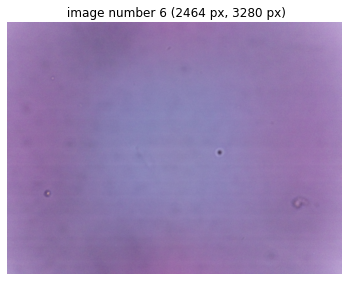

In [4]:
#test the validity of one random img
i = 6#change value to change img
img = skimage.io.imread(os.path.join(data_path, os.listdir(data_path)[i]))
im_h, im_w, im_channel = img.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(img, cmap='gray')
ax.set_title(' image number '+str(i)+' ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()


As most images contain mainly white parts, the first step is to select ROI. Here is the principle described for one image:

get the background by taking the mean of the dataset

In [302]:
np.concatenate([]).shape

ValueError: need at least one array to concatenate

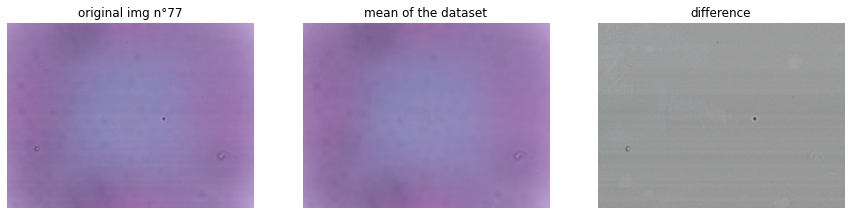

In [305]:
sum_img = np.zeros(img.shape)
hist_cum = np.zeros(256)
k=0
for file in os.listdir(data_path):
    try:
        img_k = skimage.io.imread(os.path.join(data_path,file))
        
    except:
        continue
    sum_img = img_k+sum_img
    hist,bins = np.histogram(img_k,256)
    hist_cum+=hist
    k+=1
    
mean_img = sum_img/k


fig, ax = plt.subplots(1, 3, figsize=(15, 18))

ax[0].imshow(img)
ax[0].set_title('original img n°'+str(i))
ax[0].axis('off')
ax[1].imshow(mean_img.astype(int))
ax[1].set_title('mean of the dataset')
ax[1].axis('off')
diff = img-mean_img
diff_rescale = (diff-np.min(diff))/(np.max(diff)-np.min(diff))
ax[2].imshow(diff_rescale)
ax[2].axis('off')
ax[2].set_title('difference')
plt.show()

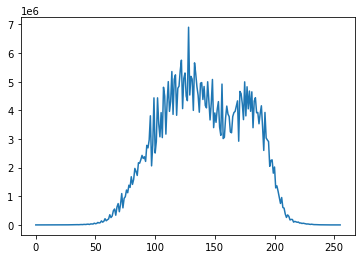

In [311]:
plt.plot(hist_cum)
threshold = threshold_otsu(hist=hist_cum)/255


In [312]:
threshold 

0.5568627450980392

In [291]:
shrink_factor = 2
#threshold = 0.4 deprecated
dil_size = 6
min_area = 10
sigma = 5

the preprocessing took: 
 - 0.02557840000008582s to shrink the image
 - 0.05790019999949436s to process the high pass filter
 - 0.06484150000142108s to binarize it
 - 0.1760703999989346s to close it
 - 0.009290100000725943s to label it
 - 0.02592740000000049s to filter it 
 ----TOTAL: 0.3596080000006623


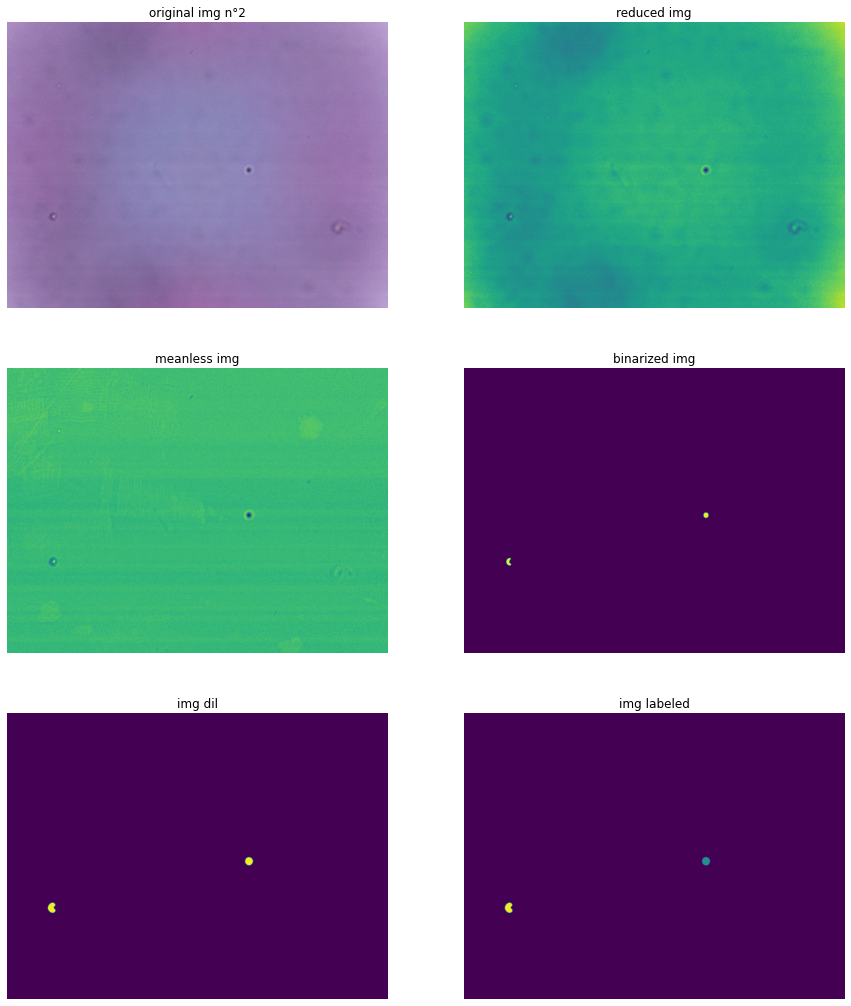

In [313]:
t0 = time.perf_counter()
#shrink the image to fasten the calculations, and turn it grey
img_small = np.sum(img[0::shrink_factor,0::shrink_factor],axis = 2)
t00 = time.perf_counter()
#substract the mean and renormalize:
diff = img_small-np.sum(mean_img[0::shrink_factor,0::shrink_factor],axis = 2)
diffn = (diff-np.min(diff))/(np.max(diff)-np.min(diff))
t1 = time.perf_counter()

#binarize
img_smooth = filters.gaussian(diffn,sigma)
threshold = threshold
img_bin = img_smooth < threshold

t3 = time.perf_counter()

#morphological op

img_dil = morphology.binary_dilation(img_bin,selem = morphology.disk(dil_size))
t4 = time.perf_counter()

#watershed
img_label, n_ROI = ndimage.label(img_dil.astype(int))
t5 = time.perf_counter()

#filter out the background
ids, count = np.unique(img_label,return_counts = True)
new_ids = np.zeros((ids[-1]+1), dtype = int)
j = 0
for i,c in zip(ids,count):
    if c != np.max(count):
            j = j+1
            new_ids[i]=j
#apply the filter:
if ids[-1]>1:
    img_filtered = new_ids[img_label[:,:]]
else:
    img_filtered = np.zeros(np.shape(img_label),dtype = int)
t6 = time.perf_counter()            


#print performances:
print('the preprocessing took: \n - '
     +str(t00-t0)+'s to shrink the image\n - '
     +str(t1-t00)+'s to process the high pass filter\n - '
     +str(t3-t1)+'s to binarize it\n - '
     +str(t4-t3)+'s to close it\n - '
     +str(t5-t4)+'s to label it\n - '
     +str(t6-t5)+'s to filter it \n ----TOTAL: '+str(t6-t0))

#plot
fig, ax = plt.subplots(3, 2, figsize=(15, 18))

ax[0,0].imshow(img)
ax[0,0].set_title('original img n°'+str(i))
ax[0,0].axis('off')

ax[0,1].set_title('reduced img')
ax[0,1].imshow(img_small)
ax[0,1].axis('off')

ax[1,0].set_title('meanless img')
ax[1,0].imshow(diffn)
ax[1,0].axis('off')

ax[1,1].set_title('binarized img')
ax[1,1].imshow(img_bin)
ax[1,1].axis('off')

ax[2,0].set_title('img dil')
ax[2,0].imshow(img_dil)
ax[2,0].axis('off')

ax[2,1].set_title('img labeled')
ax[2,1].imshow(img_filtered)
ax[2,1].axis('off')
plt.show()


In [293]:
dil_size_sharp = 15
threshold_sharp = 0.02

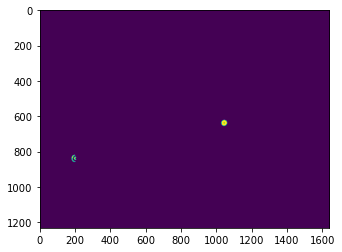

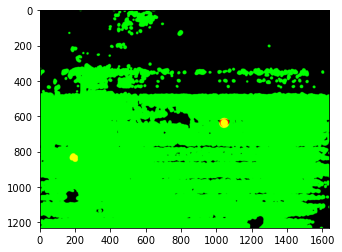

In [294]:
f1 = filters.sobel(img_smooth)
sharp = f1>threshold_sharp
sharp_ero = morphology.binary_erosion(sharp,selem=morphology.disk(3))
sharp_dil = morphology.binary_dilation(sharp_ero,selem = morphology.disk(dil_size_sharp))
sharp_label,n_sharp = ndimage.label(sharp_dil)


plt.imshow(sharp)
plt.show()

img_compound = np.zeros((img_smooth.shape[0],img_smooth.shape[1],3))
img_compound[:,:,0]=sharp_dil
img_compound[:,:,1]=img_dil
#img_compound[:,:,2]=np.logical_or(f1>0.03,img_dil)


plt.imshow(img_compound)
plt.show()

In [272]:
img_border = filters.sobel(img_small)
t1 = time.perf_counter()
threshold =0.3
#normalize the sobel filtered images
b_min = np.min(img_border)
b_max = np.max(img_border)
diff = b_max-b_min
img_bordern = (img_border-b_min)/diff
img_to_filter = np.copy(img_bordern)


img_bin_focus = img_bordern > threshold
img_close_focus = morphology.binary_dilation(img_bin_focus,selem = morphology.disk(dil_size))
np.putmask(img_to_filter, img_close_focus, 0)
img_bin_out = (img_to_filter > threshold/2)
img_close_out = morphology.binary_dilation(img_bin_out,selem = morphology.disk(dil_size))
np.putmask(img_to_filter, img_close_out, 0)
img_bin_veryout = (img_to_filter > threshold/4)
img_close_veryout = morphology.binary_dilation(img_bin_veryout,selem = morphology.disk(dil_size))


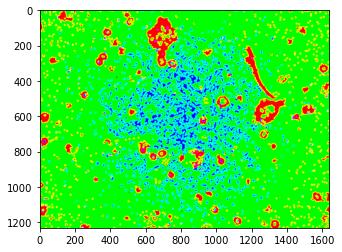

In [12]:
chanimg = np.zeros((img_close_focus.shape[0],img_close_focus.shape[1],3))
chanimg[:,:,0]=img_close_focus
chanimg[:,:,1]=img_close_out
chanimg[:,:,2]=img_close_veryout
plt.imshow(chanimg)

As the method above is not quite resilient, each ROI is treated separately to find how well it is focused

Once the images are correctly labeled, one can segment the wanted ROI and store them in a list

In [17]:
margin = 5
ROI_list = []
c_list =[]
ROI_sharp_list = []
c_sharp_list = []
for i in range(1,n_sharp+1):
    x,y = np.where(sharp_label ==i)
    xmin = 2*max(np.min(x)-margin,0)
    ymin = 2*max(np.min(y)-margin,0)
    xmax = 2*min(np.max(x)+margin,im_h//2)
    ymax = 2*min(np.max(y)+margin,im_w//2)
    c_sharp_list.append(((xmin,ymin),(xmax,ymax)))
    ROI_sharp_list.append(img[xmin:xmax,ymin:ymax])
for i in range(1,j+1):
    x,y = np.where(img_filtered ==i)
    xmin = 2*max(np.min(x)-margin,0)
    ymin = 2*max(np.min(y)-margin,0)
    xmax = 2*min(np.max(x)+margin,im_h//2)
    ymax = 2*min(np.max(y)+margin,im_w//2)
    flag = False
    for corners in c_sharp_list:
        if ((xmin-corners[0][0])**2+(ymin-corners[0][1])**2)<50*50 and (
            (xmax-corners[1][0])**2+(ymax-corners[1][1])**2)<50*50:
            flag = True
            break
    if not flag:
        c_list.append((xmin,ymin))
        ROI_list.append(img[xmin:xmax,ymin:ymax])

In [18]:
len(ROI_list)

25

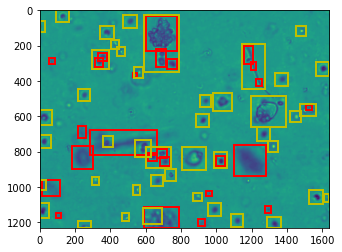

In [19]:
fig, ax = plt.subplots()
ax.imshow(diffn)
for i,ROI in enumerate(ROI_list):
    shape = ROI.shape
    rect = patches.Rectangle((c_list[i][1]//2,c_list[i][0]//2), shape[1]//2, shape[0]//2, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
for i,ROI in enumerate(ROI_sharp_list):
    shape = ROI.shape
    rect = patches.Rectangle((c_sharp_list[i][0][1]//2,c_sharp_list[i][0][0]//2), shape[1]//2, shape[0]//2, linewidth=2, edgecolor='y', facecolor='none')
    ax.add_patch(rect)

        
plt.show()

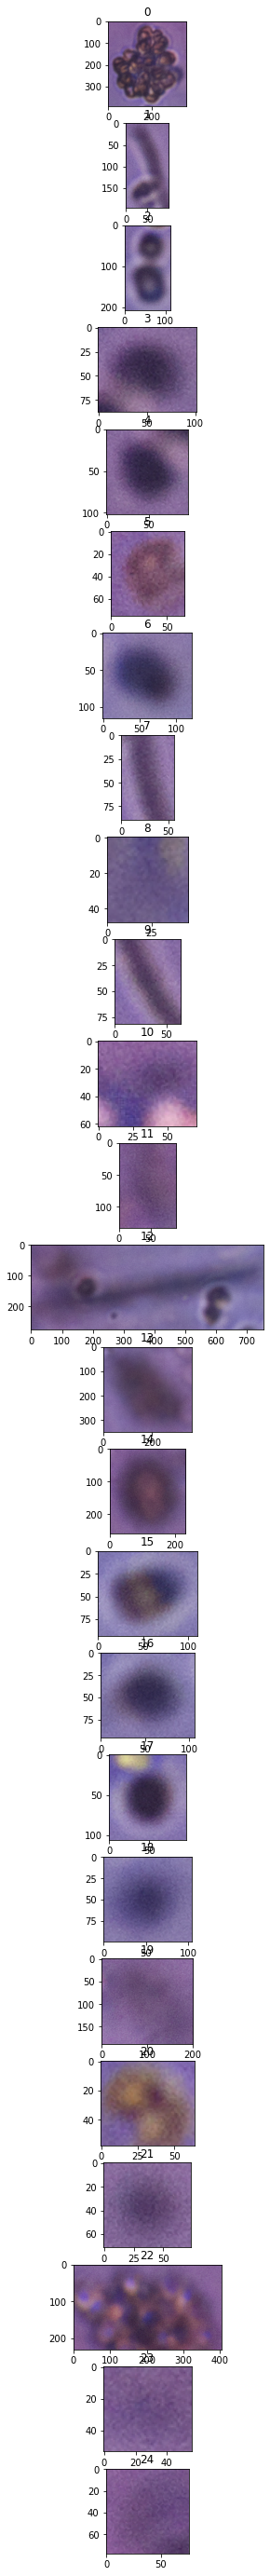

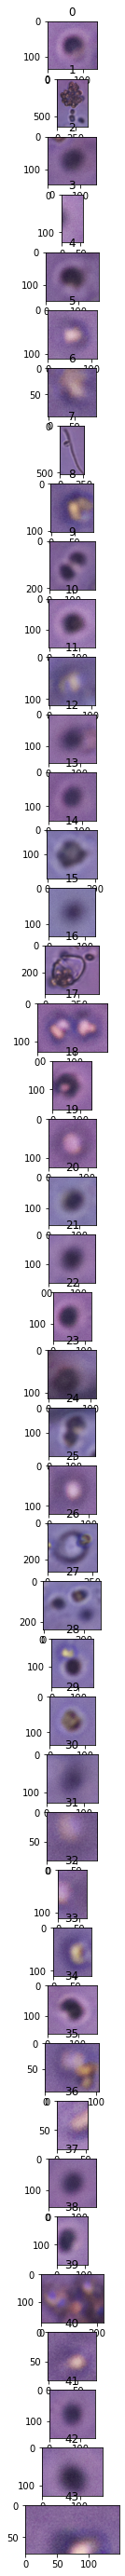

In [20]:
fig, ax = plt.subplots(len(ROI_list), figsize=(15, 50))
if len(ROI_list)>1:
    for i,ROI in enumerate(ROI_list): 
        ax[i].imshow(ROI)
        ax[i].set_title(str(i))
else:
    ax.imshow(ROI_list[0])
plt.show()
fig, ax = plt.subplots(len(ROI_sharp_list), figsize=(15, 50))
if len(ROI_sharp_list)>1:
    for i,ROI in enumerate(ROI_sharp_list): 
        ax[i].imshow(ROI)
        ax[i].set_title(str(i))
else:
    ax.imshow(ROI_sharp_list[0])

In [21]:
i = 34
ROI = ROI_list[i]
plt.imshow(ROI)

IndexError: list index out of range

In [ ]:
#normalize the ROI, then filter it with a sobel kernel
ROIg = np.mean(ROI,axis=2)
ROIn = (ROIg-np.min(ROIg))/(np.max(ROIg)-np.min(ROIg))
gaussROI = filters.gaussian(ROIn,10)
sobelROI = filters.sobel(gaussROI)#ndimage.gaussian_laplace(ROIn,5)
hist,b = np.histogram(sobelROI,100)
plt.imshow(sobelROI)
plt.show()
plt.plot(hist)
print(b[-2])
plt.show()
p50,p99 = np.percentile(sobelROI,[50,99])
print(p50/p99)
plt.imshow(sobelROI>p)

In [22]:
def wavelethisto(ROI,pad=0,normalize=True):
    ROIg = np.mean(ROI,axis=2)
    #ROIn = (ROIg-np.min(ROIg))/(np.max(ROIg)-np.min(ROIg))
    coeffs = pywt.wavedec2(ROIg, 'haar',level=None)
    coeffs1, cslice,cshape = pywt.ravel_coeffs(coeffs, axes=None)
    histo = []
    for slicedim in cslice:
        if isinstance(slicedim,dict):
            totdim = 0
            for direction in ('ad','dd','da'):
                totdim+= np.percentile(np.abs(coeffs1[slicedim[direction]]),99)
        #else:
            #totdim = np.max(np.abs(coeffs1[slicedim]))
            histo.append(totdim)
    #histo = [el/histo[0] for el in histo[1:]]
    
    if normalize:
        histo_n = [el/(2**(len(histo)-i)) for i,el in enumerate(histo)]
        histo = histo_n
    if pad > 0:
        hist_pad = np.ones(pad)*histo[0]
        hist_pad[-1:-len(histo)-1:-1]=histo[-1::-1]
        return hist_pad
    else:
        return histo

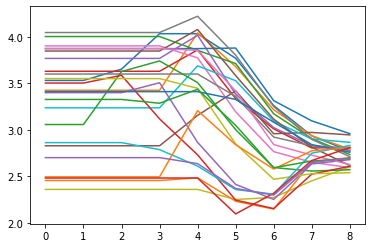

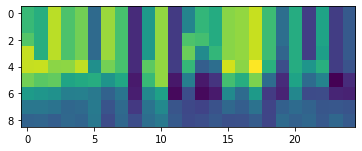

In [23]:
fig1 = plt.subplot()
#sample = [ROI_list[12],ROI_list[13],ROI_list[28],ROI_list[21]]
sample = ROI_list
pad = 13
hist_a = np.zeros(shape=(pad,len(sample)))
for i,ROI in enumerate(sample):
    hist = wavelethisto(ROI,pad = pad)
    fig1.plot(np.log(hist[4:]))
    hist_a[:,i]=np.log(hist)
    #fig1.legend([el for ])
plt.show()
plt.imshow(hist_a[4:,:])

On the image above, each ROI is represented in a column. The yellower the pixel the higher the coefficient is. If a ROI has a lot of high 

In [24]:
def takeSecond(elem,num_comp=0):
    return elem[1][num_comp]
tup = sorted(enumerate(hist_a.T),key=takeSecond)
idx = [el[0] for el in tup]

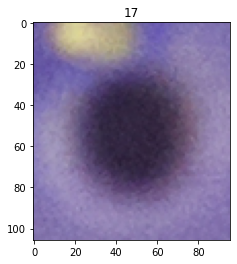

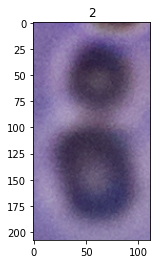

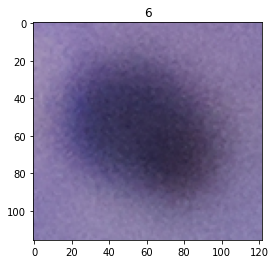

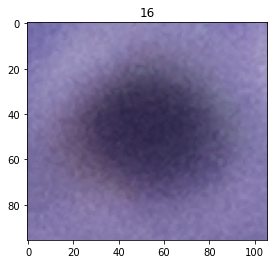

In [25]:
for i in idx[-1:-5:-1]:
    plt.imshow(ROI_list[i])
    plt.title(i)
    plt.show()

In [26]:
i = 37
ROI = ROI_list[i]
plt.imshow(ROI)
#plt.imshow(img_filtered==i+1)

IndexError: list index out of range

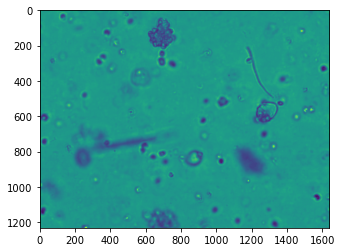

In [27]:
plt.imshow(diffn)

(404, 2318)
(198, 100, 3)


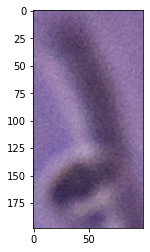

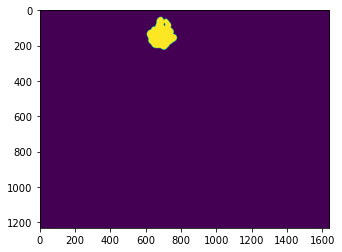

In [28]:
print(c_list[1])
print(ROI_list[1].shape)
plt.imshow(ROI_list[1])
plt.show()
plt.imshow(img_filtered==2)
plt.show()


In [29]:
shape[:2]

(76, 148)

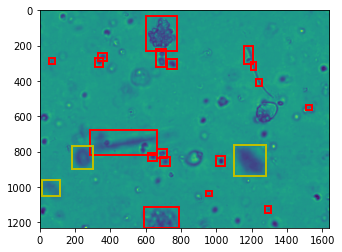

In [30]:
fig, ax = plt.subplots()
ax.imshow(diffn)
for i,ROI in enumerate(ROI_list):
    shape = ROI.shape
    if hist_a[-1,i]<hist_a[-4,i]:
        rect = patches.Rectangle((c_list[i][1]//2,c_list[i][0]//2), shape[1]//2, shape[0]//2, linewidth=2, edgecolor='r', facecolor='none')
    else:
        if np.min(shape[:2])>150:
            rect = patches.Rectangle((c_list[i][1]//2,c_list[i][0]//2), shape[1]//2, shape[0]//2, linewidth=2, edgecolor='y', facecolor='none')
    ax.add_patch(rect)

        
plt.show()

In [31]:
ROI = ROI_list[0]

In [32]:
ROIg = np.mean(ROI,axis=2)
ROIn = (ROIg-np.min(ROIg))/(np.max(ROIg)-np.min(ROIg))
coeffs = pywt.wavedec2(ROIn, 'haar')
coeffs1, cslice,cshape = pywt.ravel_coeffs(coeffs, axes=None)

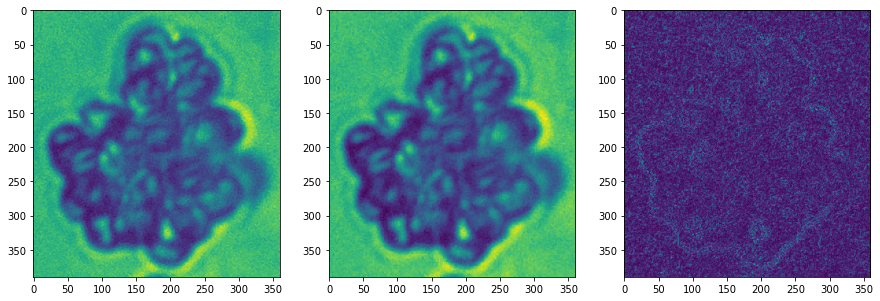

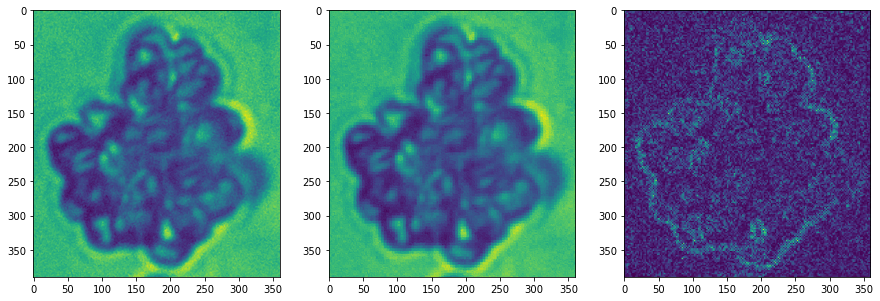

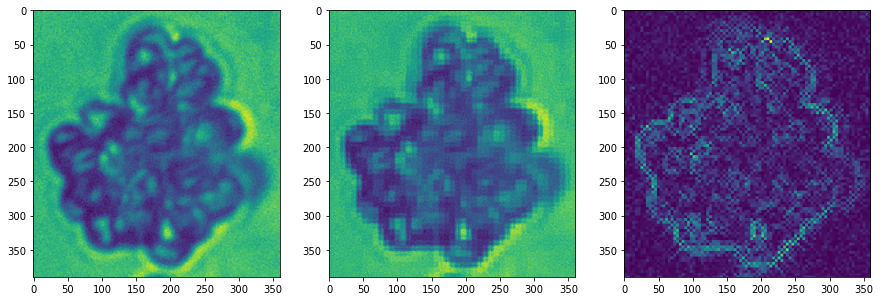

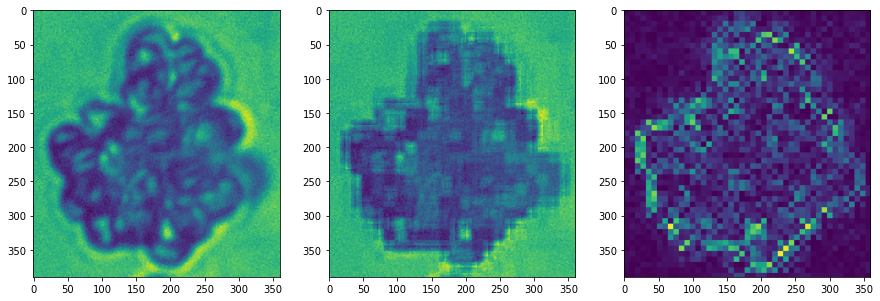

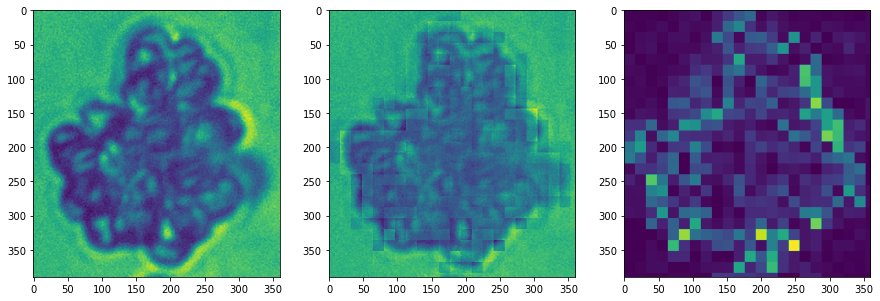

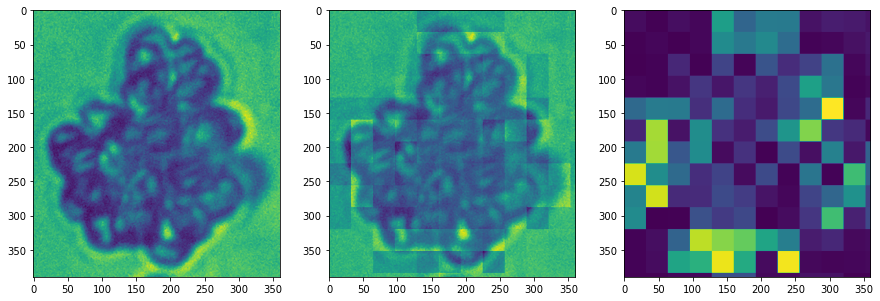

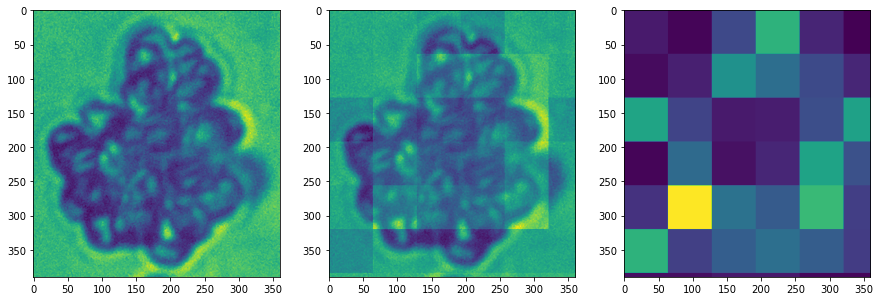

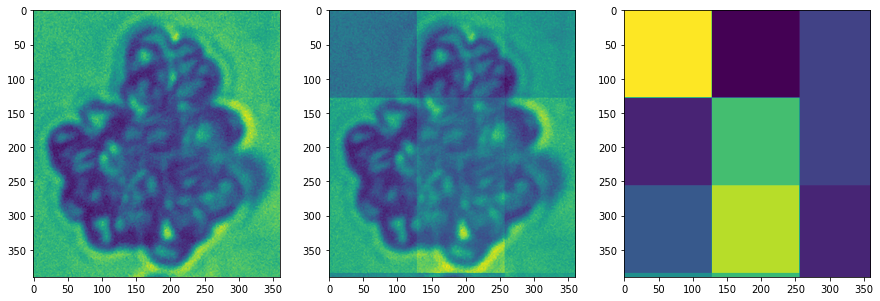

In [33]:
#build the image by removing a given coeff and comput the difference

for idx in cslice[-1:0:-1]:
        coeffs_new = np.copy(coeffs1)
        coeffs_new[idx['dd']] = 0
        coeffs_new[idx['ad']] = 0
        coeffs_new[idx['da']] = 0
        fig, ax = plt.subplots(1,3, figsize=(15, 5))
        img_rec = pywt.waverec2(pywt.unravel_coeffs(coeffs1,cslice,cshape,output_format='wavedec2'),'haar')
        img_filtered = pywt.waverec2(pywt.unravel_coeffs(coeffs_new,cslice,cshape,output_format='wavedec2'),'haar')
        img_diff = np.abs(img_rec-img_filtered)
        ax[0].imshow(img_rec)
        ax[1].imshow(img_filtered)
        ax[2].imshow(img_diff)
        plt.show()
        

In [34]:
coeffs[1]

(array([[ 24.47618911,  14.5792356 ],
        [-33.50979435,  -9.9558632 ]]),
 array([[22.03233188,  0.        ],
        [ 5.36907361,  0.        ]]),
 array([[7.33770872, 0.        ],
        [9.66656135, 0.        ]]))

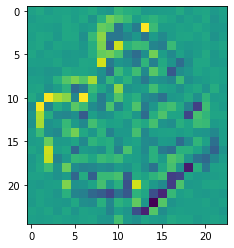

In [35]:
plt.imshow(np.sum(coeffs[5],axis=0))

In [36]:
#rec = pywt.idwt2((cA,(None,None,None)), 'haar')
rec = pywt.waverec2(coeffs, 'haar')

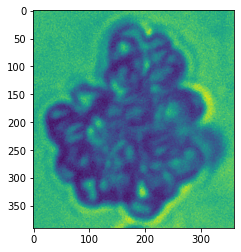

In [37]:
plt.imshow(rec)

The previously seen function have been integrated in segmentation.py file, allowing an easy reuse of them

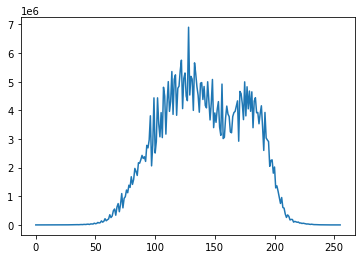

In [6]:
importlib.reload(seg) #to make sure the last version of seg is used
i = 1 #change value to change img
img_list = []
for img_name in os.listdir(data_path):
    try:
        img_list.append(skimage.io.imread(os.path.join(data_path,img_name)))
    except:
        continue   
mean_img,threshold = seg.stat_aquisition(img_list)


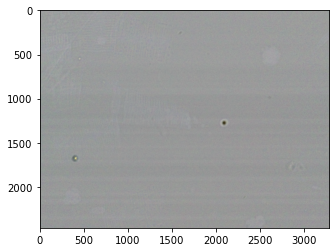

In [13]:
plt.imshow(seg.normalize(img-mean_img.astype(float)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


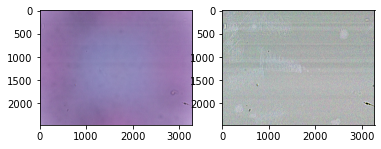

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


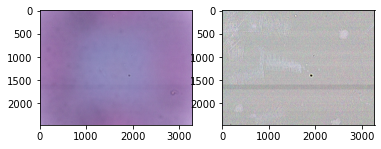

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


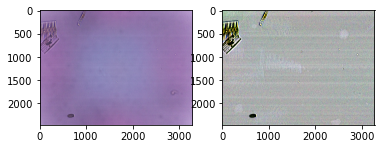

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


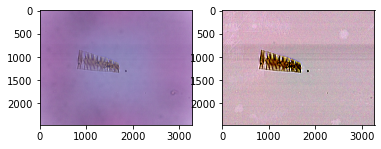

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


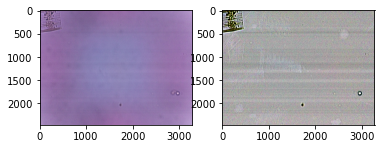

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


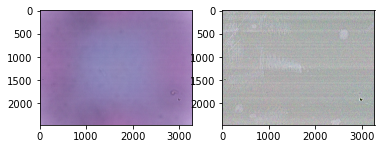

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


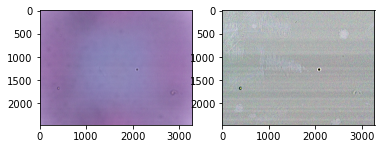

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


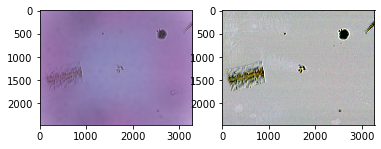

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


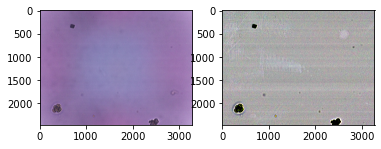

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


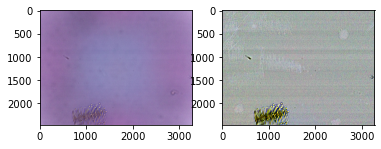

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


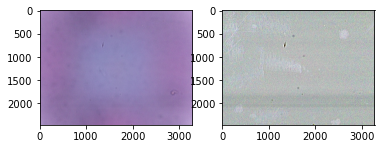

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


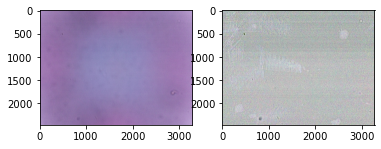

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


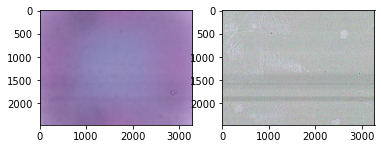

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


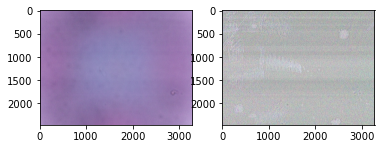

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


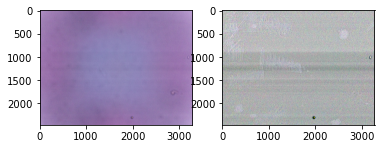

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


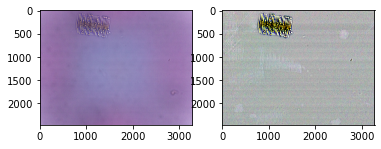

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


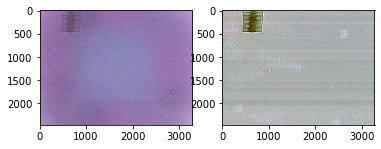

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


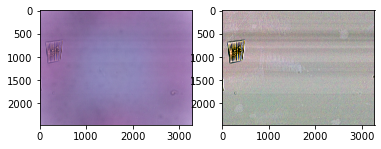

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


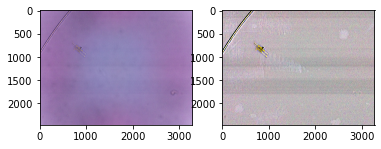

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


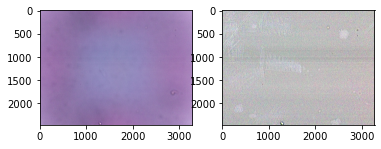

In [7]:
importlib.reload(seg) #to make sure the last version of seg is used

imgn_list, threshold_aq = seg.standardize_aquisition(img_list,plot=True)

In [70]:
threshold_aq

0.5546875

In [71]:
imgn_list[i].dtype

dtype('float64')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


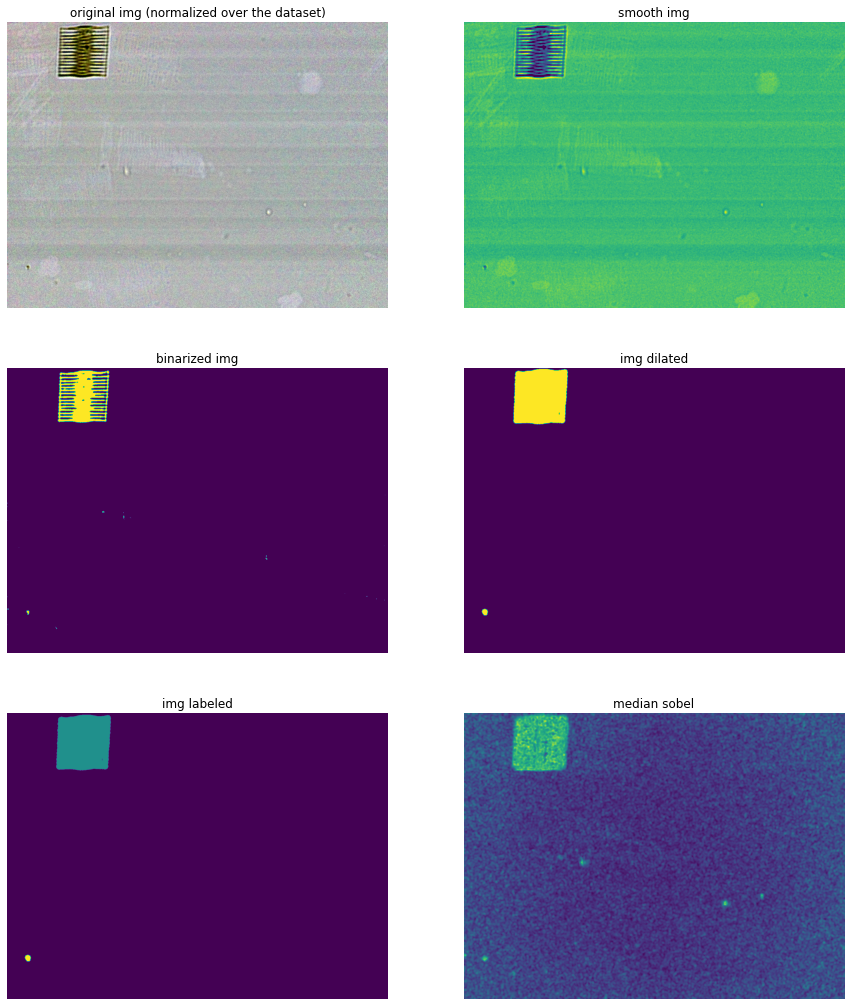

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


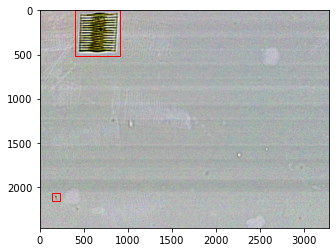

In [24]:
importlib.reload(seg) #to make sure the last version of seg is used

i = 16
img = imgn_list[i]
img_label,c,c = seg.label_standard(img,threshold_aq,plot=True,return_features=True)
ROI_list = seg.segment(img, img_label,shrink_factor = 1,plot =True,margin = 20)


The preprocessing steps are used on all images, and several features are already stored:

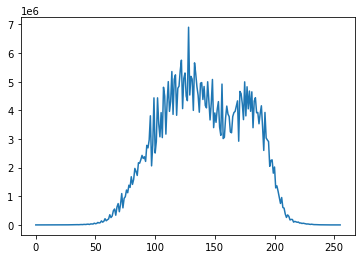

In [8]:
importlib.reload(seg) #to make sure the last version of seg is used

img_list = []
for img_name in os.listdir(data_path):
    try:
        img_list.append(skimage.io.imread(os.path.join(data_path,img_name)))
    except:
        continue
img_mean,threshold = seg.stat_aquisition(img_list)

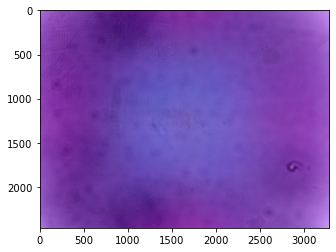

In [4]:
plt.imshow(seg.normalize(img_mean))

In [52]:
importlib.reload(seg) #to make sure the last version of seg is used

ROI_list = []
tl_list =[]

bundle_list = []
for i,img in enumerate(img_list):
    print(str(i+1)+'/'+str(len(img_list)),end='\r')
    img_label,img_median_sobel,img_smooth = seg.label_img_noBG(img,img_mean,threshold,return_features=True)
    t = filters.threshold_otsu(img_median_sobel)
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(img_smooth)
    ax[1].imshow(img_median_sobel>t)
    plt.show()
    #get the number of ROI and their sizes
    n, counts = np.unique(img_label,return_counts=True)
    counts = counts[1:]#get rid of the background
    margin = 20
    ROI_img,tl_img,mask_img = seg.segment(img, img_label,shrink_factor = 1,plot =False,
                                 return_tl=True, return_mask = True, margin = margin)
    ROI_meanless_img = seg.segment(img_smooth,img_label,shrink_factor=1,margin=margin)
    ROI_sobel_img = seg.segment(img_median_sobel,img_label,shrink_factor=1,margin=margin)
    
    for count,ROI,ROI_meanless,tl,mask,sobel in zip(counts,ROI_img,ROI_meanless_img,tl_img,mask_img,ROI_sobel_img):
        bundle = {}
        bundle['source img']=i
        bundle['ROI']=ROI
        bundle['ROI_meanless']=ROI_meanless
        bundle['area']=count
        bundle['position']=tl
        bundle['mask']= mask
        bundle['sobel']=sobel
        bundle_list.append(bundle)
    ROI_list.append(ROI_img)
    tl_list.append(tl_img)

RuntimeError: array type dtype('float16') not supported

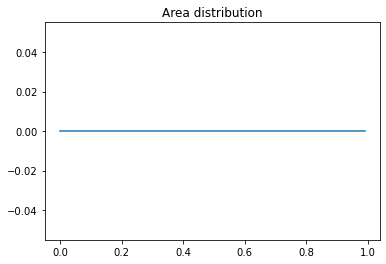

In [8]:
histo, bins = np.histogram([bundle['area'] for bundle in bundle_list],100)
fig = plt.subplot()
fig.plot(bins[:-1],histo)
fig.title.set_text('Area distribution')
#fig.set_xticks(range(len(bins)-1),bins[:-1], minor=False)

In [10]:
len(bundle_list)

0

AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

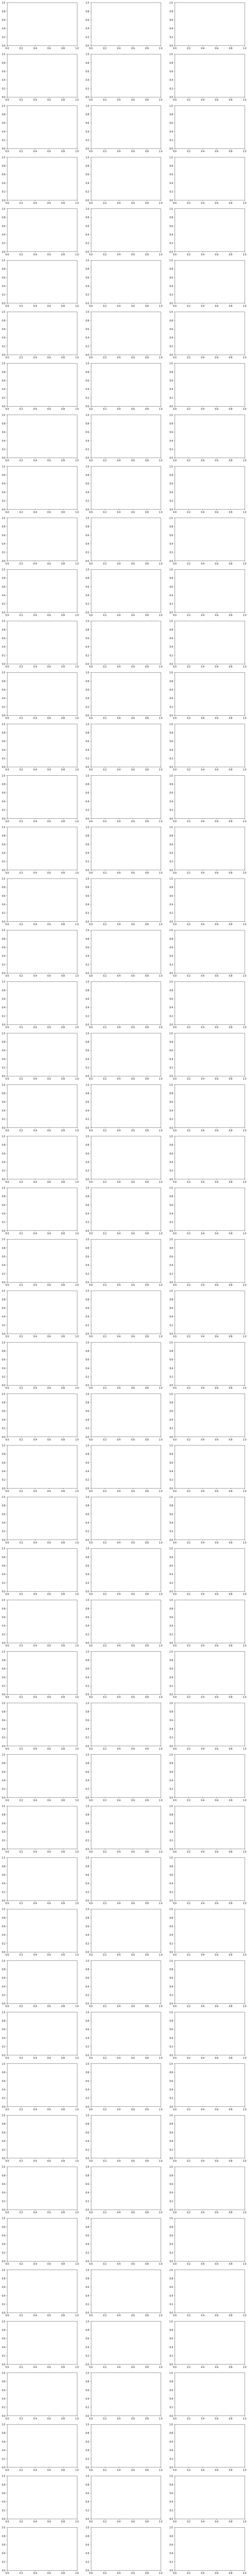

In [9]:
fig, ax = plt.subplots(50,3, figsize=(18, 200))
if len(bundle_list)>1:
    for i in range(50):
        idx = np.random.choice(len(bundle_list))
        bundle = bundle_list[idx]
        ax[i][0].imshow(bundle['ROI_meanless'])
        ax[i][0].set_ylabel("{:.2f}".format((np.var(bundle['ROI_meanless']))))
        ax[i][1].imshow(bundle['sobel'],cmap='jet',vmin=0,vmax = 255)
        ax[i][1].set_ylabel(str(idx))
        ax[i][2].imshow(filters.sobel(bundle['ROI_meanless']))
else:
    ax.imshow(bundle_list[0]['ROI_meanless'])

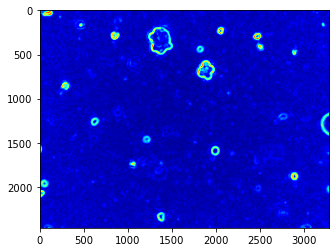

In [275]:
#test = filters.gaussian(diffn)
#test = seg.normalize(np.sum(bundle_list[92]['img_meanless'],axis=2))
#test = filters.sobel(bundle_list[92]['ROI_meanless'])
test = img_median_sobel
plt.imshow(test,cmap='jet')


In [216]:
from skimage.filters.rank import entropy,gradient,otsu,median,autolevel
from skimage.filters import threshold_otsu
from skimage.morphology import ball,disk



In [278]:
np.unique(test)

array([  5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 18

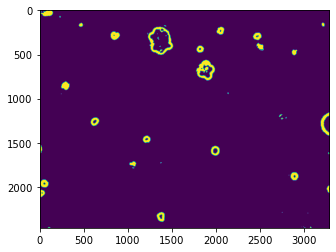

In [280]:


plt.show()

## Post processing:
As a first set of feature is extracted in order to easily filter the ROI: The area and the sharpness (quantified by the 95th percentile of the sobel filtered image)

In [ ]:
#When more than one object is in the ROI, with one on the background and one in the foreground,
#it is interesting to brake it down:

The list of ROI is saved in order not to recompute the segmentation too often

In [10]:
pickle_folder = os.path.join('PMID2019', 'pickle_ROI')
pickle_path = os.path.join(data_base_path, pickle_folder)

In [13]:
save_file = 'ROI_list404.pickle'

with open(os.path.join(pickle_path,save_file), 'wb') as f:
    pickle.dump(ROI_list, f)

In [11]:
with open(os.path.join(pickle_path,'ROI_list2.pickle'),'rb') as f:
    ROI_list = pickle.load(f)

In [12]:
len(ROI_list)

12392

In [29]:
BigROI_list = []
for ROI in ROI_list:
    if np.min(ROI.shape[0:-1])>512:
        BigROI_list.append(ROI)

In [30]:
len(BigROI_list)

2201

In [31]:
np.min(ROI.shape[0:2])

392

In [32]:
ROI.shape

(450, 392, 3)

In [35]:

for el in BigROI_list:
    if(np.min(el.shape[:-1])<256):
        print(el.shape)

In [36]:
save_file = 'BigROI_list404.pickle'

with open(os.path.join(pickle_path,save_file), 'wb') as f:
    pickle.dump(BigROI_list, f)